## Normalization

### Initialization

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


# initialize parameters
selectchannel=19 # channel 20 (python index from 0 )is Cz
baselinelength=300 #in data point

### Load Data

The EEG and EMG signals are collected, while the subject stands on a balance beam tring to regain balance when perturbation events triggerd. The channel 20 of the EEG is analysised. The alpha and beta are pre-processed two signal bands on 8-12 Hz and 15-20 Hz respectively. ind is time stamp of the perturbation event.

epochnum is the number of events.

EMGdata: 6268808x2
fdata_alpha: 6268808x34
fdata_beata: 6268808x34



In [2]:
mat_data = scipy.io.loadmat('EEGdata')

fdata_alpha = mat_data['fdata_alpha']
fdata_beta = mat_data['fdata_beta']

ind = np.squeeze(mat_data['ind'])

epochnum = len(ind)
channelNo = fdata_alpha.shape[1]

### Normalize data

Normalize both alpha band and beta band, Use mean data as the baseline

$$
E R D / E R S(\%)=\frac{\text { Signal }_{\text {power }}-\text { baseline }_{\text {power }}}{\text { baseline }_{\text {power }}} \times 100 \%
$$

In [3]:
# EEG epoch data

for band in range(2):
    if band == 0:
        ffdata = fdata_alpha
    elif band == 1:
        ffdata = fdata_beta

    # cut epoch
    epoch = np.zeros((epochnum, 1000+baselinelength, channelNo))

    for i in range(epochnum):
        epoch[i,:,:] = ffdata[ind[i]-baselinelength:ind[i]+1000,:]

    # ERD/ERS  (Event related, disynchonization)

    y = np.zeros((epochnum, 1000+baselinelength, channelNo))    
    for i in range(epochnum):
        for j in range(channelNo):
            y[i,:,j] =(epoch[i,:,j] - np.mean(epoch[:,:,j],0))**2
            y[i,:,j] = (y[i,:,j]/np.mean(y[i,:baselinelength,j]))*100
        
    if band==0:
        ER_alpha = np.mean(y,0)
    elif band==1:   
        ER_beta = np.mean(y,0)

### Plot
Plot the normalized and averaged data on both alpha and beta bands with the tigger event

In [4]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

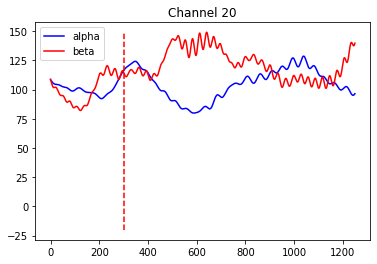

In [7]:
# tmp_alpha = ER_alpha[:,selectchannel]
# tmp_beta = ER_beta[:,selectchannel]

# tmp_alpha=savgol_filter(ER_alpha[:,selectchannel],50,2)
# tmp_beta=savgol_filter(ER_beta[:,selectchannel],50,2)

tmp_alpha = moving_average(ER_alpha[:,selectchannel],50)
tmp_beta = moving_average(ER_beta[:,selectchannel],50)



plt.figure()
plt.plot(tmp_alpha,'b', label='alpha')
plt.plot(tmp_beta,'r', label='beta')
plt.plot([baselinelength,baselinelength],[np.min([tmp_alpha, tmp_beta])-100, np.max([tmp_alpha,tmp_beta])],'r--')
plt.title('Channel '+str(selectchannel+1))
plt.legend()

plt.show()

## Event Detection

### Initialization

In [14]:
from threading import local
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from filters import filter_2sIIR, filter_2sFIR

In [8]:
DispCh = 1   # select a channel to display  
SampleRate = 2000 #in Hz

Res_MagThres = 1 # the threshold of res. band magnitude
EMG_BPcutooff = [70, 500]  # cutoff frequency of bandpass filter, in Hz
EMG_Lcutoff = 4          # cutoff frequency of lowpass filter, in Hz



### Load Data

Reperation data (Resdata) and the corresponding EMG data (EMGdata) are collected.

* EMGdata in channel 1-4
* Resdata in channel 5



In [9]:
mat_data = scipy.io.loadmat('EMGdata.mat')

data = mat_data['data']

EMGdata=data[:,:4]
Resdata=data[:,4]

### Peak value detect

1. Remove DC offset by substract the mean value below 0
2. Use threshold_1 to get the data above the threshold.
3. Get gap index
4. Get maxium index of the original data skip gaps
> pay attention to the boundary conditions


In [10]:
# detect the peak value of each resp. cycle using signal of resp. band

oResdata = Resdata - np.mean(Resdata[Resdata<0]) # remove DC



#  perform double-threshold method to detect peak value
# threshold 1: magnitude

(indmag,)=np.nonzero(oResdata>1)    #find the index with value larger than 1

# threshold 2: define window

diffind=indmag[1:]-indmag[:-1]
(indgap,)=np.nonzero(diffind>1)

indmax=[]   # the location of index with maximal value in each cycle


for i in range(len(indgap)+1):
    if i==0:
        local_index = np.argmax(oResdata[indmag[:indgap[i]]])  #be careful with index!!!!!
        indmax.append(local_index+indmag[0])
    elif i == len(indgap):
        local_index = np.argmax(oResdata[indmag[indgap[i-1]+1:]])
        indmax.append(local_index + indmag[indgap[i-1]+1])
    else:
        local_index = np.argmax(oResdata[indmag[indgap[i-1]+1:indgap[i]]])
        indmax.append(local_index + indmag[indgap[i-1]+1])

### Filters
bandpass filter, rectify, lowpass filter

In [50]:
fEMGdata = filter_2sIIR(EMGdata.T,EMG_BPcutooff,SampleRate,6, "bandpass" )
rfEMGdata = abs(fEMGdata)
frfEMGdata = filter_2sIIR(rfEMGdata, EMG_Lcutoff, SampleRate,6,"lowpass" )
pfrfEMGdata=frfEMGdata[DispCh,:]/np.max(frfEMGdata[DispCh:])*100   # percentage

Text(0.5, 0, 'time (s)')

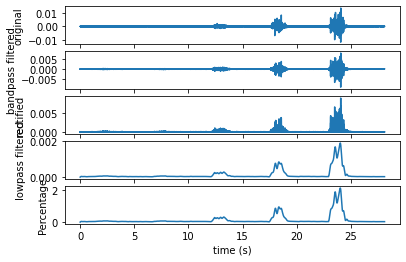

In [51]:
taxis = np.arange(data.shape[0])/SampleRate # define the time axis based on the data length and sampling rate

plt.figure() 
plt.subplot(5,1,1)
plt.plot(taxis,EMGdata[:,DispCh]) # original signal
plt.ylabel('original')

plt.subplot(5,1,2)
plt.plot(taxis,fEMGdata[DispCh,:]) # bandpass filtered signal
plt.ylabel('bandpass filtered')

plt.subplot(5,1,3)
plt.plot(taxis,rfEMGdata[DispCh,:]) # rectified signal
plt.ylabel('rectified')

plt.subplot(5,1,4)
plt.plot(taxis,frfEMGdata[DispCh,:]) # lowpass filtered signal
plt.ylabel('lowpass filtered')

plt.subplot(5,1,5)
plt.plot(taxis,pfrfEMGdata) # percentage signal
plt.ylabel('Percentage')
plt.xlabel('time (s)')


### Plot the data

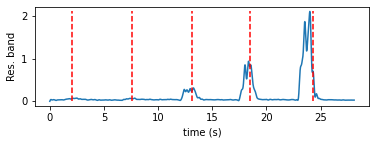

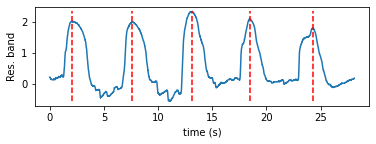

In [52]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(taxis,pfrfEMGdata)

for i in range(len(indmax)):
    plt.plot([taxis[indmax[i]],taxis[indmax[i]]], [np.min(pfrfEMGdata),np.max(pfrfEMGdata)], 'r--')
    plt.ylabel("Res. band")
    plt.xlabel("time (s)")

plt.subplot(2,1,2)
plt.plot(taxis, oResdata)

for i in range(len(indmax)):
    plt.plot([taxis[indmax[i]],taxis[indmax[i]]], [np.min(oResdata),np.max(oResdata)], 'r--')
    plt.ylabel("Res. band")
    plt.xlabel("time (s)")

plt.show()